[View in Colaboratory](https://colab.research.google.com/github/saitota/ProgrammingKnock100/blob/master/Chapter04_Q30_Q39.ipynb)

# :muscle: 前書き
詳細は[第1章](https://qiita.com/saitotak/items/73852ecb7cc4b10b42a5)参照、引き続き言語処理100本ノックの第3章を回答していきます。本章では TBD


# :muscle: 第4章: 形態素解析
> 夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt)）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．
> なお，問題37, 38, 39は[matplotlib](http://matplotlib.org/)もしくは[Gnuplot](http://www.gnuplot.info/)を用いるとよい．

UTF-8,LF の1万行程度の日本語プレーンテキストでした。形態素解析と統計のライブラリを存分に使うことになりそうな感じです。

```text:neko.txt
一

　吾輩は猫である。
名前はまだ無い。

　どこで生れたかとんと見当がつかぬ。
何でも薄暗いじめじめした所でニャーニャー泣いていた事だけは記憶している。
（以下略）
```

## ⚾ 30. 形態素解析結果の読み込み
> 形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．


## 下準備として
- ファイルダウンロード
- janomeのインストール

In [2]:
import urllib.request
urllib.request.urlretrieve('http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt','./neko.txt')


('./neko.txt', <http.client.HTTPMessage at 0x7f3dd09b0080>)

In [3]:
!pip install janome

### 解0-1 janomeによる形態素解析と、neko.txt.janome のテキスト作成（おそい）
- MeCab ではなく janome をインストールします、なぜならインストールが簡単だったから。
- `janome.tokenizer` を使って形態素解析します
    - [janome package — janome.tokenizer](http://mocobeta.github.io/janome/api/janome.html#module-janome.tokenizer)
- やたら遅かったので、開始・終了 時間を計測するコードを入れました
- 実測：42sec


In [4]:
from janome.tokenizer import Tokenizer
import janome
import datetime

print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# WriteのたびにOpen
with open ('./neko.txt','r',encoding='utf-8') as file_temp:
    for line in file_temp:
        # 形態素解析して保存
        for token in t.tokenize(line, stream=True):
            with open ('./neko.txt.janome-01','a',encoding='utf-8') as file_janome:
                    file_janome.write(str(token) + '\n')

print('end:' + str(datetime.datetime.now()))

'''
一	名詞,数,*,*,*,*,一,イチ,イチ
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
（以下略）
'''


start:2018-05-28 11:47:24.653929
end:2018-05-28 11:48:10.635433


'\n一\t名詞,数,*,*,*,*,一,イチ,イチ\n吾輩\t名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ\nは\t助詞,係助詞,*,*,*,*,は,ハ,ワ\n猫\t名詞,一般,*,*,*,*,猫,ネコ,ネコ\nで\t助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ\nある\t助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル\n。\t記号,句点,*,*,*,*,。,。,。\n名前\t名詞,一般,*,*,*,*,名前,ナマエ,ナマエ\n（以下略）\n'

### 解0-2 高速化
- メモリ枯渇を鑑み 形態素解析→write を繰り返すようにしてみましたが、やたらと時間がかかったため、一括で書き込むようにして高速化を図ります
- 実測：29sec

In [5]:
print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# Openしてから
with open ('./neko.txt','r',encoding='utf-8') as file_temp , open ('./neko.txt.janome-02','a',encoding='utf-8') as file_janome:
    for line in file_temp:
        # 形態素解析して保存
        for x in t.tokenize(line, stream=True):
            file_janome.write(str(x) + '\n') 
            

print('end:' + str(datetime.datetime.now()))

start:2018-05-28 11:48:12.501624
end:2018-05-28 11:48:44.072151


### 解0-3 さらに高速化
- それでも遅い気がしたので、書き込み部分をリスト内包表記にしました、多少早くなった
- 実測：27sec


In [6]:
print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# 一部リスト内包表記
with open ('./neko.txt','r',encoding='utf-8') as file_temp , open ('./neko.txt.janome-03','a',encoding='utf-8') as file_janome:
    for line in file_temp:
        # 形態素解析して保存
        [file_janome.write(str(x) + '\n') for x in t.tokenize(line, stream=True)]
            

print('end:' + str(datetime.datetime.now()))

start:2018-05-28 11:48:44.825142
end:2018-05-28 11:49:15.808801


### 解0-4 さらに高速化・・・失敗
- 読みにくいですがぜんぶリスト内包表記にしました
- 実測：88sec
  - 遅くなった何故。。。

In [7]:
print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# リスト内包表記
with open ('./neko.txt','r',encoding='utf-8') as file_temp , open ('./neko.txt.janome-04','a',encoding='utf-8') as file_janome:
    [
        [
            file_janome.write(str(x) + '\n')
            for x in t.tokenize(y, stream=True)
        ]
        for y in file_temp
    ]

print('end:' + str(datetime.datetime.now()))

start:2018-05-28 11:49:16.429262
end:2018-05-28 11:49:47.734940


### 解1 neko.txt.janome のテキスト作成
-  形態素はタブ区切り、品詞等の分類はカンマ区切りなので成型します

In [8]:
with open ('./neko.txt.janome-04','r',encoding='utf-8') as file_temp:
    text = file_temp.readlines()

lst_janome=[]
for line in text:
    lst_janome.append(
        { 'surface': line.split('\t')[0], # 表層形
          'pos'    : line.split('\t')[1].split(',')[0], # 品詞
          'pos1'   : line.split('\t')[1].split(',')[1], # 品詞細分類1
          'base'   : line.split('\t')[1].split(',')[6]   # 基本形
        })

for i in range(10):
    print(lst_janome[i])
  

{'surface': '一', 'pos': '名詞', 'pos1': '数', 'base': '一'}
{'surface': '吾輩', 'pos': '名詞', 'pos1': '代名詞', 'base': '吾輩'}
{'surface': 'は', 'pos': '助詞', 'pos1': '係助詞', 'base': 'は'}
{'surface': '猫', 'pos': '名詞', 'pos1': '一般', 'base': '猫'}
{'surface': 'で', 'pos': '助動詞', 'pos1': '*', 'base': 'だ'}
{'surface': 'ある', 'pos': '助動詞', 'pos1': '*', 'base': 'ある'}
{'surface': '。', 'pos': '記号', 'pos1': '句点', 'base': '。'}
{'surface': '名前', 'pos': '名詞', 'pos1': '一般', 'base': '名前'}
{'surface': 'は', 'pos': '助詞', 'pos1': '係助詞', 'base': 'は'}
{'surface': 'まだ', 'pos': '副詞', 'pos1': '助詞類接続', 'base': 'まだ'}



## ⚾ 31. 動詞
> 動詞の表層形をすべて抽出せよ．

## 解1 普通にループ

In [9]:
lst_res = []
for janome in lst_janome:
    if janome.get('pos') == '動詞':
        lst_res.append(janome.get('surface'))

print(lst_res[::10])    

['生れ', '煮', '見', 'し', '坐っ', '助から', '付い', 'られ', '見', '渡っ', '廻り', 'もぐり込ん', '忍び込ん', '考える', 'ねぶっ', 'れ', '云う', '来', '眺め', 'し', 'いう', '帯び', '垂らす', '出来', 'られ', '得る', 'やむを得ん', '割り込む', 'くる', '至っ', '怒っ', '来たそ', '隣り', 'いる', 'すまし', '待つ', 'し', 'おら', '吹き出す', 'やめ', 'やっ', '感ずる', '飛ぶ', 'ある', '来', '見', '執っ', 'する', 'れ', '交ぜ', '思っ', 'なっ', '打ち', '知ら', 'くれ', 'する', '養う', '心付か', '抛', 'ある', 'いる', 'し', 'せる', 'する', 'いる', '生じ', '見える', '見違える', 'なる', '吐く', 'とっ', 'とろ', 'し', 'し', '引き受ける', '這い', 'え', 'がっ', 'する', 'し', 'とっ', '儲け', 'なっ', 'い', '見え', '云う', 'する', 'せ', '得る', 'いる', 'なっ', 'ある', '力め', '出さ', '信じよ', 'いる', 'なる', 'おっ', '知ら', 'い', '笑っ', 'いる', 'いる', 'ある', 'なっ', 'こぼし', '立て', '帰る', '取ら', 'いる', '見', '持っ', '思っ', '思い', '見', '云う', '得る', '出来', '這入っ', 'かかわら', 'いう', 'し', 'わかる', 'し', 'ある', 'なっ', 'あれ', 'れ', '極め', 'なれ', 'いる', '求め', 'いる', '引張る', '食い', 'なら', 'やり', '思い', '見る', '分ら', 'せ', 'もし', '出る', '透かし', '換え', '思う', 'し', 'いる', 'あっ', 'とっ', 'いる', 'しゃくい', 'いる', 'い', '食い', '濁っ', 'ある', '利く', 'し', '上っ', '突き付け', '行っ', 'い', 'いる', '剃っ', '

## 解2. 内容表記と重複排除
- このくらいのループであればリスト内包表記のほうがいいかも
- `set()` による重複排除

In [10]:
lst_res = list(set([x.get('surface') for x in lst_janome if x.get('pos') == '動詞']))
print(lst_res[::10])

['求め', '刺し通し', 'つかれ', '起こす', '切り開い', '返る', '聞こえよ', '端折り', '招い', '舂き', '広げ', '弱ら', 'ほ', '瘠せ', '突き飛ばし', '掻き', '斬り', '味わう', '正し', '足し', '立た', '真似れ', '極め', 'ふるえ', '勤まる', 'いただく', '言い放っ', '云わ', 'もっ', '惚れ込ま', '聞きゃ', '逸する', '化け', '引き上げ', '差出す', '繙く', '静まり返っ', '判ぜ', '真似る', 'あたわ', 'なり', '取り立て', '述べる', 'もぐり込む', 'こぼれ落ちる', '祝い', '起こし', 'すぼめる', '暮し', '召し上がり', '書きゃ', '陥れる', '属する', '登っ', '急き込ん', '使わ', 'いろ', '生ずる', '持ち切っ', '飛込ん', '届く', 'くれれ', '受合え', 'あるけ', '焦れ', '避ける', '叩い', '載せ', '問いかける', '集まる', 'しかめ', 'かえる', '喫せ', '連ね', '伺い', '酬い', 'かしこまり', '枉げ', '名乗る', '示す', '進も', '下りる', '帰さ', '弁ずる', '得よ', 'なぐさみ', '浮ん', '送', '頼み', '見透かさ', 'ちょろまかし', '充たさ', '塗っ', 'はす', 'こり', '有れ', '押し込め', '恐れ入る', '食っ', '近寄り', '退い', 'あう', 'とき', 'ひやかす', '訳し', 'つき合わ', '中る', '立ちすくん', '吸い取ら', '競っ', '律す', '縮める', 'すまし', '飛び込む', '居ら', '沈ん', '降りる', '蒙る', '来ん', '持ち上げる', '取り払っ', '立ち行く', '名乗っ', '違っ', '退ける', '整え', '分け', 'わく', '驚かし', '掠め', '勧める', '笑わ', '定め', '評する', '詰め込む', '引く', 'ひねっ', '見詰める', '驚い', '焦げ', '寝つき', '己惚れ', '立ち寄っ', '過ぎる', '欲する', '着ける', 


## ⚾ 32. 動詞の原形
> 動詞の原形をすべて抽出せよ．


## 解1. 内包表記
- 原型=基本形（base）のようです

In [11]:
st_res = list(set([x.get('base') for x in lst_janome if x.get('pos') == '動詞']))
print(lst_res[::10])

['求め', '刺し通し', 'つかれ', '起こす', '切り開い', '返る', '聞こえよ', '端折り', '招い', '舂き', '広げ', '弱ら', 'ほ', '瘠せ', '突き飛ばし', '掻き', '斬り', '味わう', '正し', '足し', '立た', '真似れ', '極め', 'ふるえ', '勤まる', 'いただく', '言い放っ', '云わ', 'もっ', '惚れ込ま', '聞きゃ', '逸する', '化け', '引き上げ', '差出す', '繙く', '静まり返っ', '判ぜ', '真似る', 'あたわ', 'なり', '取り立て', '述べる', 'もぐり込む', 'こぼれ落ちる', '祝い', '起こし', 'すぼめる', '暮し', '召し上がり', '書きゃ', '陥れる', '属する', '登っ', '急き込ん', '使わ', 'いろ', '生ずる', '持ち切っ', '飛込ん', '届く', 'くれれ', '受合え', 'あるけ', '焦れ', '避ける', '叩い', '載せ', '問いかける', '集まる', 'しかめ', 'かえる', '喫せ', '連ね', '伺い', '酬い', 'かしこまり', '枉げ', '名乗る', '示す', '進も', '下りる', '帰さ', '弁ずる', '得よ', 'なぐさみ', '浮ん', '送', '頼み', '見透かさ', 'ちょろまかし', '充たさ', '塗っ', 'はす', 'こり', '有れ', '押し込め', '恐れ入る', '食っ', '近寄り', '退い', 'あう', 'とき', 'ひやかす', '訳し', 'つき合わ', '中る', '立ちすくん', '吸い取ら', '競っ', '律す', '縮める', 'すまし', '飛び込む', '居ら', '沈ん', '降りる', '蒙る', '来ん', '持ち上げる', '取り払っ', '立ち行く', '名乗っ', '違っ', '退ける', '整え', '分け', 'わく', '驚かし', '掠め', '勧める', '笑わ', '定め', '評する', '詰め込む', '引く', 'ひねっ', '見詰める', '驚い', '焦げ', '寝つき', '己惚れ', '立ち寄っ', '過ぎる', '欲する', '着ける', 

## ⚾ 33. サ変名詞
> サ変接続の名詞をすべて抽出せよ．

## 解1. 内包表記
- 品詞細分類1がサ変接続のものを探します

In [12]:
lst_res = list(set([x.get('base') for x in lst_janome if x.get('pos1') == 'サ変接続']))
print(lst_res[::10])

['外出', 'どんと', '活躍', '連勝', '挺', '処置', '絞殺', '辞儀', '開陳', '承諾', '銷沈', '予約', '達観', '紅葉', '賭', '往復', 'かさん', '後進', '倹約', '了解', '困窮', '傑出', '治療', '増長', '伴奏', '統計', '圧迫', '晩酌', '影響', '逸出', '曝露', '嘲笑', '焦慮', '糾合', '劇変', '征伐', '休心', '幸い', '身動き', '拝趨', '交渉', '料理', '養成', '向上', '再拝', '豹変', 'にこにこ', '読誦', '突起', '戦闘', '鎮座', '演奏', '彷徨', '廃業', '背面', '宙返り', '晴れ晴れ', '診断', '帰', '専有', '蚕食', '督', '応戦', '上下', '退校', '専断', '威嚇', '弁難', '彩色', '供', '合奏', '交叉', '報知', '記', '矯正', '服膺', '怒号', '赤面', '一座', 'ストライキ', '乱暴', '左右', 'せいせい', '歓喜', '相対', '保証', '幽閉', '保護', '狂乱', '証明', '充満', '奉呈', '同宿', '号', '連続', '宣戦', '眺望', '吐出', '晴々', '設備', '邪魔', '履行', '永眠', '通用', '苦心', '注意', '放歌', '増減', '花見', 'きが', 'いらいら', '老衰', '配当', '参堂', '不足', '投函', '掃除', '爆発', '遠征', '乱入', '欠伸', '微動', '低頭', '打算', '感心', '挨拶', '連戦', '対立']


## ⚾ 34. 「AのB」
> 2つの名詞が「の」で連結されている名詞句を抽出せよ．

## 解1. 普通にループ
- 名詞 の 名詞 を探します

In [13]:
lst_res = []
for i,janome in enumerate(lst_janome):
    if janome.get('base') == 'の':
        if (lst_janome[i-1].get('pos') == '名詞') and (lst_janome[i+1].get('pos') == '名詞'):
          lst_res.append(lst_janome[i-1].get('base') + janome.get('base') + lst_janome[i+1].get('base'))

print(lst_res[::20])

['彼の掌', '彼の書生', '主人の傍', '家の書生', '今更のよう', '主人の彩色', '純粋の黒', '吾輩の心臓', '彼の鼻', '黒の子分', '元の通り', 'ハリソンの歴史', '赤松の間', '主人のよう', '吾輩の主人', '門の格子', '実のところ', '後の猫', '壺の中', '障子の隙', '主人のよう', '主人の心', '二絃琴の師匠', '贅沢の結果', '二の真理', '在来の通り', '欣羨の意', '理詰の虚言', '初春の長閑', '主人の笑い声', 'つもりのところ', '方面の研究', '娼家の下婢', '念の体', '男の事', '感謝の意', '世紀の今日', '自分の境遇', '毛の病気', '平等の水彩', 'トチメンボーの復讐', '明治の文壇', '他の松', '博士の夫人', '遠くの方', '門の内', '水の労', '縮緬の羽織', '主人の我儘', '障子のうち', '教師の所', '吾輩の写真', '居士の事', '自分の家', '先刻の不平', '冊の内', '一流の論理', '迷亭の専断', '縄の一端', '御存じの平均', '埒の方', '女の声', '金田の倉', '私の家', '寒月の方', '車屋の神', '地球の磁気', '枚の絵葉書', '月並の標本', 'ステッキの代り', '活眼の士', '尻尾の先', '無用の長物', '車夫の声', '夜光の明', 'さんの話', '長吉の方', '尻尾の先', '忠告の通り', '垣の隙', '護の恐れ', '眉の根', '鼻の持主', '何のため', '空の縄張', '雪隠の横', '色の口', '僧の癖', '奴の娘', '天気の日', '右手の指', '供の袖', '時の印象', '鼻の中', '自分のため', '心の故', '下の方', '腹の内', '人の悪口', '本人の随意', '迷亭の食い気', '元のよう', '迷亭の答え', '近来の珍', 'ものの息女', '派の元祖', '智識の問屋', '贔負の尊公', '雪の夜', '目下の状態', '鼠の糞', '狼藉の練', '柳行李の間', '俗人の考', '失敗の痕', '神の製作', '未来の事件', '柳行李の辺', '山の芋の箱', '寝室の方', '

## ⚾ 35. 名詞の連接
> 名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．


## 解1. 普通にループ
- 名詞 の繰り返しを探します
- 名詞×5以上 を求めてみました

In [14]:
lst_res = []
lst_tmp = []
for janome in lst_janome:
    if janome.get('pos') == '名詞':
         lst_tmp.append(janome.get('surface'))
    else:
        lst_tmp.clear()
    if(len(lst_tmp) > 4): #ほんとは1が条件
        lst_res.append(''.join(lst_tmp))

print(lst_res[::10])

['壱円五十銭', '是非共二三十', '四時十五分前', '八万八千八百八十本', '千七百八十', '帰泉院殿黄鶴', '明治三十八年', '十二円五十', '十年一狐裘', '三日三晩手', '弥次馬兼援兵', '珍野苦沙弥先生虎', '明治十一年九月廿八', '際武右衛門君', '五六十本半紙', '六十二回六十', '三毛子さん三毛子さん', '二三日前年始', '猫誉信女南無阿弥陀仏南無阿弥陀仏', '四百六十五行', '十二三年以前', '五二十四時間', '明治三十八年何月何日戸締り', '十二円五十銭', 'みんな七十五日以上経過', '事六十年前これ', '段奉賀上候陳', '警視庁刑事巡査吉田虎', '武右衛門君下', '——おい苦沙弥先生', '名人理学士水島寒月', '壱円五十銭', '是非共二三十', '四時十五分前', '八万八千八百八十本', '千七百八十', '帰泉院殿黄鶴', '明治三十八年', '十二円五十', '十年一狐裘', '三日三晩手', '弥次馬兼援兵', '珍野苦沙弥先生虎', '明治十一年九月廿八', '際武右衛門君', '五六十本半紙', '六十二回六十', '三毛子さん三毛子さん', '二三日前年始', '猫誉信女南無阿弥陀仏南無阿弥陀仏', '四百六十五行', '十二三年以前', '五二十四時間', '明治三十八年何月何日戸締り', '十二円五十銭', 'みんな七十五日以上経過', '事六十年前これ', '段奉賀上候陳', '警視庁刑事巡査吉田虎', '武右衛門君下', '——おい苦沙弥先生', '名人理学士水島寒月']


## ⚾ 36. 単語の出現頻度
> 文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．


## 解1. collections型
- `collections` の `most_common([n])`ｄ集計
    - [8.3. collections](https://docs.python.jp/3/library/collections.html#collections.Counter.most_common)
- Pandasとか使うのかと思った

In [15]:
import collections

lst_tmp = []
for janome in lst_janome:
    lst_tmp.append(janome.get('surface'))

cnt = collections.Counter(lst_tmp)
lst_commons = cnt.most_common()

print(lst_commons[:30:]) # 上位30件

  

[('の', 36776), ('。', 29944), ('て', 27460), ('、', 27088), ('は', 25680), ('に', 24956), ('を', 24268), ('と', 22020), ('が', 21344), ('た', 15952), ('で', 15220), ('「', 12924), ('」', 12900), ('も', 9916), ('ない', 9560), ('だ', 9452), ('し', 9288), ('から', 8128), ('ある', 6908), ('な', 6452), ('ん', 6276), ('か', 6120), ('いる', 4996), ('事', 4828), ('へ', 4136), ('う', 3972), ('する', 3968), ('もの', 3920), ('です', 3892), ('云う', 3748)]



## ⚾ 37. 頻度上位10語
> 出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．




## 解1. matplotlib.pyplot でグラフ表示
- `matplotlib.pyplot`  でグラフ化する
    - [matplotlib.pyplot — Matplotlib 2.2.2 documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot)
- インストールから必要だと思ったけれど。colab環境には既に入っていた
- 日本語フォント `fonts-ipafont-gothic` をインストール
- フォント指定には `matplotlib.font_manager` を使用

In [16]:
!pip install matplotlib
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-17ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


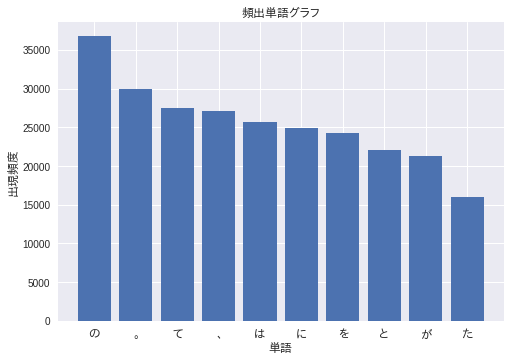

In [17]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

lst_words = [] 
lst_count = [] 

for lst_common in lst_commons[:10:]:
  lst_words.append(lst_common[0])
  lst_count.append(lst_common[1])

# 日本語フォント
fp = FontProperties(fname='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf') 

# ラベル設定
plt.title('頻出単語グラフ', fontproperties=fp)
plt.xlabel('単語', fontproperties=fp) # 横軸
plt.ylabel('出現頻度', fontproperties=fp) # 縦軸

#データプロット
plt.xticks(range(10),lst_words,fontproperties=fp) # 横軸
plt.bar(range(10),lst_count) # 縦軸
plt.show() # 表示


## ⚾ 38. ヒストグラム
> 単語の出現頻度のヒストグラム（横軸に出現頻度，縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け．

### 解1. matplotlib.hist でグラフ表示
- 手集計してグラフ表示します
- ラベルがグチャってなる…

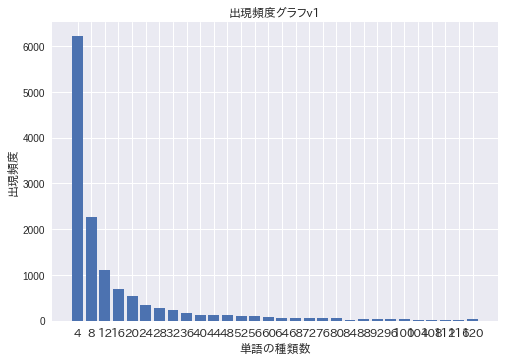

In [51]:
lst_cnt = {}
lst_cnt2 = {}

for lst_common in lst_commons:
    lst_cnt[lst_common[1]] = lst_cnt.get(lst_common[1],0) + 1

lst_cnt2 =dict(sorted(lst_cnt.items(), key=lambda x: x[0])) #逆順ソート

# 日本語フォント
fp = FontProperties(fname='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf') 

# ラベル設定
plt.title('出現頻度グラフv1', fontproperties=fp)
plt.xlabel('単語の種類数', fontproperties=fp) # 横軸
plt.ylabel('出現頻度', fontproperties=fp) # 縦軸

v = [int(v) for k,v in lst_cnt2.items()] # 縦軸
k = [int(k) for k,v in lst_cnt2.items()] # 横軸

#データプロット
plt.xticks(range(30) ,k[:30:],fontproperties=fp) # 横軸
plt.bar(range(30),v[:30:])# 縦軸

plt.show() # 表示

## 解2. matplotlib.hist でグラフ表示
- `xticks` ではなく `hist` を使用すると、ヒストグラムを計算して描画してくれます
  - [matplotlib.pyplot.hist — Matplotlib 2.2.2 documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html)

In [0]:
# 日本語フォント
fp = FontProperties(fname='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf') 





## ⚾ 39. Zipfの法則
> 単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．
